# Statistik & QA

In [1]:
import pandas as pd

In [2]:
!wget https://datanizing.com/heise/newsticker2019.csv

--2020-10-27 18:19:58--  https://datanizing.com/heise/newsticker2019.csv
Resolving datanizing.com (datanizing.com)... 37.221.195.1
Connecting to datanizing.com (datanizing.com)|37.221.195.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33368578 (32M) [application/octet-stream]
Saving to: ‘newsticker2019.csv’

newsticker2019.csv  100%[===================>]  31.82M  8.22MB/s    in 4.4s    

2020-10-27 18:20:04 (7.27 MB/s) - ‘newsticker2019.csv’ saved [33368578/33368578]



In [3]:
docs = pd.read_csv("newsticker2019.csv", index_col="id", parse_dates=["time"])

In [4]:
docs

,headline,lead,text,time
id,,,,
3723775,Niantic klagt gegen Betrug bei Pokémon GO,Alternative Apps für Pokemon GO und Ingress si...,"""Die beklage Partei Global++ ist ein Zusammens...",2019-06-18 12:17:00
4094233,Apple TV+: Start in der Türkei unklar,Die Einführung von Apple TV+ könnte in der Tür...,Vergangenen Montag stellte Tim Cook den neuen ...,2019-03-28 10:03:00
4178923,Radeon VII für den Spielermarkt abgespeckt,Nach der Vorstellung auf der CES sind weitere ...,Die Überraschung war nicht nur beim Publikum g...,2019-01-18 17:47:00
4190120,Bastelboards und steckbare 7-Segment-Anzeigen ...,Für Kurzentschlossene gibt es derzeit einiges ...,Jetzt aber schnell: Einige Kampagnen laufen ni...,2019-01-29 07:00:00
4240170,Werkstattberichte: Neues aus den Fablabs und d...,"Wo entstehen neue Makerspaces, welche Termine ...","Über die Feiertage, den Chaos Communication Co...",2019-01-08 09:00:00
...,...,...,...,...
4624983,Amazon eröffnet Obdachlosenunterkunft – in sei...,"Im Frühjahr 2020 soll die Unterkunft eröffnen,...",Die Hilfsorganisation Mary's Shelter will Anfa...,2019-12-31 14:23:00
4624993,E-Auto mit Solarmodulen Sion: Sono Motors verf...,"Die 50 Millionen Euro als Ziel seines ""Communi...","32,5 Millionen Euro hat Sono Motors in seinem ...",2019-12-31 15:05:00
4625000,AKW Philippsburg 2 geht endgültig vom Netz,Mit Block 2 des Atomkraftwerks Philippsburg wi...,Nach 35 Jahren Betrieb geht am Dienstag in Phi...,2019-12-31 15:40:00


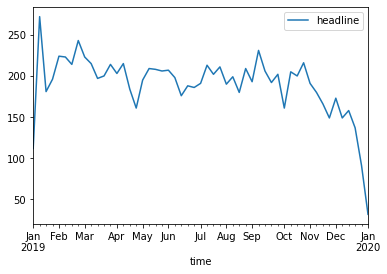

In [5]:
docs.set_index("time").resample("W").agg({"headline": "count"}).plot()

In [6]:
import re
docs["full_text"] = docs["headline"] + " " + docs["lead"] + " " + docs["text"]
docs["simple_text"] = docs["full_text"].str.lower().replace(re.compile("[\-,\.\!\?\:\;\"\+\&\'„“–\(\)\[\]]"), " ")
[t[0:120] for t in docs["simple_text"].values[0:10]]

['niantic klagt gegen betrug bei pokémon go alternative apps für pokemon go und ingress sind betreiber niantic ein dorn im',
 'apple tv   start in der türkei unklar die einführung von apple tv  könnte in der türkei schwierig werden  denn dort ist ',
 'radeon vii für den spielermarkt abgespeckt nach der vorstellung auf der ces sind weitere details zu amds kommender high ',
 'bastelboards und steckbare 7 segment anzeigen   crowdfunding projekte für maker für kurzentschlossene gibt es derzeit ei',
 'werkstattberichte  neues aus den fablabs und der makerszene wo entstehen neue makerspaces  welche termine stehen an und ',
 'künstliche intelligenz in maker projekten nutzen um ki in eigenen projekten zu nutzen  muss man nicht selbst algorithmen',
 'smart home  pi steuert funksteckdosen eine eigenbau lösung für die heimautomation lässt sich mit einem raspi und günstig',
 'reingeschaut  mcdonald s wartenummern mit bluetooth beacon bei mcdonald s gibt es neuerdings wartenummern mit integriert',


In [7]:
apple = docs[docs["simple_text"].str.contains("apple")]
len(apple)

1327

In [8]:
[t[0:120] for t in apple["simple_text"].values[10:30]]

['apple erwägt iphone x produktion in indien neben älteren modellen könnten künftig auch topgeräte in indien entstehen   a',
 'verbogenes ipad pro  apple sieht keinen grund zum handeln ein hardwaremanager hat gegenüber kunden betont  die tablets e',
 'schlechte verkaufszahlen des iphone  apple senkt umsatzprognose der konzern hat seine prognose für das weihnachtsquartal',
 'iphone krise  apple aktie bricht ein  cook spricht vor versammelter mannschaft apple aktionären steht ein übler tag bevo',
 'iphone verkaufsverbot in deutschland tritt in kraft qualcomm setzt durch  dass apple bestimmte smartphone modelle nicht ',
 'zur iphone krise  wie apple gegenhalten könnte der versuch  sinkende smartphone verkäufe durch höhere preise zu kompensi',
 'ces 2019  faltphones  rollbare tvs und alles mit 5g die größten trends der wichtigsten technikmesse der welt  auf der ce',
 'kurseinbruch  wall street korrigiert apple kursziel nach unten nach der umsatzwarnung reagieren die analysten und reduzi',


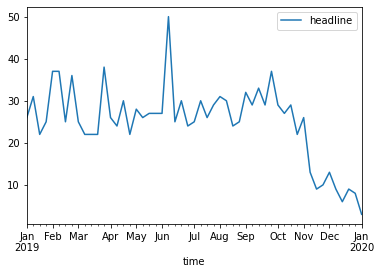

In [9]:
apple.set_index("time").resample("W").agg({"headline": "count"}).plot()

# Co-Occurrence

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv.fit_transform(docs["simple_text"])

<10077x170437 sparse matrix of type '<class 'numpy.int64'>'
	with 2610720 stored elements in Compressed Sparse Row format>

In [11]:
cv = CountVectorizer(min_df=10, max_df=0.3)
cv.fit_transform(docs["simple_text"])

<10077x22026 sparse matrix of type '<class 'numpy.int64'>'
	with 1782259 stored elements in Compressed Sparse Row format>

In [12]:
from collections import Counter, defaultdict
from tqdm import tqdm
c = defaultdict(lambda: Counter())
voc = cv.get_feature_names()
window = 5 # sollte ungerade sein
skip = (window - 1) // 2
for doc in tqdm(docs["simple_text"]):
    tokens = doc.split(" ")
    for i, w in enumerate(tokens):
        if w in voc:
            for j in range(max(0, i-skip), i):
                if tokens[j] in voc:
                    c[w][tokens[j]] += 1
            for j in range(i+1, min(i+1+skip, len(tokens))):
                if tokens[j] in voc:
                    c[w][tokens[j]] += 1

100%|██████████| 10077/10077 [1:09:52<00:00,  2.40it/s]


In [13]:
c["apple"].most_common(10)

[('angebote', 1104),
 ('watch', 616),
 ('iphone', 588),
 ('tv', 390),
 ('pay', 325),
 ('series', 206),
 ('pro', 189),
 ('macbook', 164),
 ('ipad', 156),
 ('xr', 154)]

In [14]:
c["iphone"].most_common(5)

[('apple', 588), ('11', 523), ('iphone', 422), ('xr', 397), ('xs', 332)]

In [15]:
c["ipad"].most_common(5)

[('iphone', 261), ('pro', 259), ('apple', 156), ('air', 108), ('mini', 104)]

In [16]:
c["macbook"].most_common(5)

[('pro', 300), ('air', 248), ('apple', 164), ('space', 67), ('13', 63)]

# Embeddings

In [17]:
texts = [t.split(" ") for t in docs["simple_text"]]

## word2vec

### Wörter

In [18]:
from gensim.models import Word2Vec

In [19]:
model_word = Word2Vec(texts, min_count=5, workers=8)

In [20]:
len(model_word.wv.vectors)

43665

In [21]:
model_word.wv.most_similar("apple")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('apples', 0.8140634298324585),
 ('swatch', 0.7276209592819214),
 ('iphone', 0.6934888362884521),
 ('konzern', 0.6553730368614197),
 ('w7', 0.6265036463737488),
 ('spotify', 0.6033220887184143),
 ('rakuten', 0.5937657952308655),
 ('ipad', 0.576071560382843),
 ('app', 0.5705763101577759),
 ('dogs', 0.5661699771881104)]

In [22]:
model_word.wv.most_similar("iphone")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ipad', 0.7772069573402405),
 ('iphones', 0.7156007289886475),
 ('apple', 0.6934888958930969),
 ('macbook', 0.658629298210144),
 ('xs', 0.6556370854377747),
 ('apples', 0.6460402011871338),
 ('ipod', 0.6354448795318604),
 ('ipads', 0.6268852949142456),
 ('xr', 0.5983282327651978),
 ('lbe', 0.5958917140960693)]

In [23]:
model_word.wv.most_similar("ipad")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('macbook', 0.8336524963378906),
 ('iphone', 0.7772069573402405),
 ('ipod', 0.7680411338806152),
 ('iphones', 0.7554835081100464),
 ('mac', 0.7476865649223328),
 ('ipados', 0.7464133501052856),
 ('airpods', 0.7427020072937012),
 ('touch', 0.7302615642547607),
 ('se', 0.7177237272262573),
 ('homepod', 0.6988859176635742)]

In [24]:
model_word.wv.most_similar("macbook")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('powerbeats', 0.855581521987915),
 ('ipad', 0.8336523771286011),
 ('imac', 0.804637610912323),
 ('p30', 0.7437822818756104),
 ('2018er', 0.7381508946418762),
 ('matepad', 0.7345247268676758),
 ('macbooks', 0.7298455238342285),
 ('einstiegsmodell', 0.7283972501754761),
 ('contra', 0.7137743830680847),
 ('xr', 0.7131432890892029)]

In [25]:
model_word.wv.doesnt_match(["apple", "microsoft", "google", "siemens"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'siemens'

In [26]:
model_word.wv.doesnt_match(["hund", "katze", "maus", "python"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'python'

Apple - ? = Microsoft - Windows

Apple - Microsoft + Windows = ?

In [27]:
model_word.wv.most_similar(positive=["apple", "windows"], 
                                   negative=["microsoft"],  topn=4)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ipad', 0.6880113482475281),
 ('iphone', 0.6671098470687866),
 ('ios', 0.6421608328819275),
 ('macos', 0.6420041918754578)]

In [28]:
model_word.wv.most_similar(positive=["microsoft", "iphone"],
                            negative=["apple"], topn=4)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('office', 0.6355632543563843),
 ('windows', 0.6341711282730103),
 ('support', 0.6214010715484619),
 ('betriebssystem', 0.6107650995254517)]

In [29]:
model_word.wv.most_similar(positive=["android", "apple"],
                            negative=["iphone"], topn=4)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('google', 0.6546690464019775),
 ('microsoft', 0.6291525363922119),
 ('googles', 0.5922869443893433),
 ('play', 0.5914747714996338)]

### Phrasen

In [30]:
from gensim.models import Phrases

In [31]:
entity_transformer = Phrases(texts)

In [32]:
model_phrase = Word2Vec(entity_transformer[texts], min_count=5, workers=8)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [33]:
model_phrase.wv.most_similar("apple")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('apples', 0.8193793296813965),
 ('iphone', 0.767998218536377),
 ('das_unternehmen', 0.7449650168418884),
 ('konzern', 0.727474570274353),
 ('qualcomm', 0.7199925184249878),
 ('apple_pay', 0.6974214315414429),
 ('samsung', 0.6903120279312134),
 ('spotify', 0.6825749278068542),
 ('angeblich', 0.6784695386886597),
 ('hersteller', 0.6596424579620361)]

In [34]:
model_phrase.wv.most_similar("iphone")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ipad', 0.852360725402832),
 ('iphones', 0.8074420690536499),
 ('apples', 0.7793833017349243),
 ('itunes', 0.7719288468360901),
 ('apple', 0.767998218536377),
 ('app_store', 0.7468429803848267),
 ('macs', 0.7446247935295105),
 ('smartphone', 0.7423650026321411),
 ('ios', 0.7343221306800842),
 ('siri', 0.7297263741493225)]

In [35]:
model_phrase.wv.most_similar("ipad")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('iphone', 0.8523608446121216),
 ('itunes', 0.8433439135551453),
 ('ios', 0.8427009582519531),
 ('ipados', 0.8338557481765747),
 ('apple_watch', 0.82839035987854),
 ('macs', 0.8205642700195312),
 ('apple_tv', 0.8189723491668701),
 ('home', 0.8117574453353882),
 ('ios_13', 0.8094501495361328),
 ('homepod', 0.808333158493042)]

In [36]:
model_phrase.wv.most_similar("macbook")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ipad_7', 0.9132460951805115),
 ('apple_arcade', 0.9037639498710632),
 ('iphone_x', 0.8974732160568237),
 ('ipad_pro', 0.8918949961662292),
 ('honor', 0.8856772780418396),
 ('homepod', 0.8837292194366455),
 ('axon_10', 0.8796002864837646),
 ('spitzenmodell', 0.8782423734664917),
 ('2019er', 0.8777965307235718),
 ('keyboard', 0.8717341423034668)]

In [37]:
model_phrase.wv.doesnt_match(["apple", "microsoft", "google", "siemens"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'siemens'

In [38]:
model_phrase.wv.doesnt_match(["hund", "katze", "maus", "python"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'python'

Apple - ? = Microsoft - Windows

Apple - Microsoft + Windows = ?

In [39]:
model_phrase.wv.most_similar(positive=["apple", "windows"], 
                                   negative=["microsoft"],  topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ipad', 0.8085050582885742),
 ('iphone', 0.7722153663635254),
 ('apple_watch', 0.7692807912826538),
 ('ios', 0.726838231086731),
 ('macs', 0.7239227294921875),
 ('itunes', 0.7173039317131042),
 ('mac', 0.7146221399307251),
 ('apple_tv', 0.7112205028533936),
 ('iphones', 0.7045139074325562),
 ('homepod', 0.6998356580734253)]

## fastText

In [ ]:
from gensim.models import FastText

In [ ]:
model_fast = FastText(texts, min_count=5, workers=8)

In [ ]:
model_fast.wv.most_similar("apple", topn=4)

[('applecare', 0.95626300573349),
 ('apply', 0.9344683289527893),
 ('ripple', 0.9113011360168457),
 ('apples', 0.9108171463012695)]

In [ ]:
model_fast.wv.most_similar("iphone")

[('wiphone', 0.9659565091133118),
 ('phone', 0.9413676261901855),
 ('fairphone', 0.8999027013778687),
 ('iphones', 0.894962728023529),
 ('ipcc', 0.8394544124603271),
 ('ipc', 0.8318714499473572),
 ('ipv6', 0.8227308988571167),
 ('ipmi', 0.8009897470474243),
 ('symphony', 0.7873231172561646),
 ('ipad', 0.7813636064529419)]

In [ ]:
model_fast.wv.most_similar("ipad")

[('ipads', 0.9310046434402466),
 ('ipados', 0.9187688231468201),
 ('ipc', 0.9123362302780151),
 ('ipod', 0.8925362825393677),
 ('iptv', 0.8664849400520325),
 ('ipmi', 0.8629794120788574),
 ('ipcc', 0.8623977899551392),
 ('pad', 0.8546111583709717),
 ('ipv6', 0.8480024337768555),
 ('touchpad', 0.8459989428520203)]

In [ ]:
model_fast.wv.most_similar("macbook")

[('macbooks', 0.9674311876296997),
 ('macro', 0.894782543182373),
 ('macs', 0.8648595809936523),
 ('mac', 0.8593849539756775),
 ('maciej', 0.847758412361145),
 ('macpro', 0.8463297486305237),
 ('macintosh', 0.8362990617752075),
 ('ipad', 0.8333460092544556),
 ('macau', 0.8294320106506348),
 ('ibook', 0.8205217123031616)]

In [ ]:
model_fast.wv.doesnt_match(["apple", "microsoft", "google", "siemens"])

'siemens'

In [ ]:
model_fast.wv.doesnt_match(["hund", "katze", "maus", "python"])

'python'

In [ ]:
model_fast.wv.most_similar(positive=["google", "windows"], 
                                   negative=["microsoft"],  topn=10)

[('android', 0.7076705694198608),
 ('ws', 0.7076213359832764),
 ('droid', 0.7052445411682129),
 ('androidx', 0.7035408020019531),
 ('odroid', 0.6929407715797424),
 ('window', 0.673803448677063),
 ('andromeda', 0.6619945168495178),
 ('kaios', 0.6515532732009888),
 ('vbios', 0.6453526020050049),
 ('ios', 0.645186722278595)]

## gloVe

In [ ]:
!wget https://datanizing.com/heise/glove-w2v.txt

In [ ]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format("glove-w2v.txt")

In [ ]:
glove.most_similar("apple", topn=4)

[('iphone', 0.8117432594299316),
 ('apples', 0.810858964920044),
 ('konzern', 0.7563344836235046),
 ('ipad', 0.6838310956954956)]

In [ ]:
glove.most_similar("iphone")

[('apple', 0.8117432594299316),
 ('ipad', 0.807164192199707),
 ('xr', 0.7900763750076294),
 ('xs', 0.787955641746521),
 ('apples', 0.6737732887268066),
 ('webseite', 0.673195481300354),
 ('iphones', 0.66579669713974),
 ('max', 0.6585527658462524),
 ('ios', 0.6558831930160522),
 ('watch', 0.6531574726104736)]

In [ ]:
glove.most_similar("ipad")

[('iphone', 0.807164192199707),
 ('mac', 0.7805591225624084),
 ('macbook', 0.7536984086036682),
 ('pro', 0.7314266562461853),
 ('ios', 0.7118662595748901),
 ('ipod', 0.7111266255378723),
 ('mini', 0.696607232093811),
 ('apple', 0.6838310956954956),
 ('touch', 0.667559802532196),
 ('xs', 0.6483808755874634)]

In [ ]:
glove.most_similar("macbook")

[('air', 0.8195577263832092),
 ('ipad', 0.7536984086036682),
 ('imac', 0.7499493360519409),
 ('mini', 0.7339105606079102),
 ('angebote', 0.6395155787467957),
 ('befallen', 0.6369203329086304),
 ('pro', 0.6262161135673523),
 ('space', 0.6157272458076477),
 ('ipod', 0.605150043964386),
 ('i5', 0.5987260341644287)]

In [ ]:
glove.most_similar(positive=["apple", "windows"], 
                                   negative=["microsoft"],  topn=10)

[('iphone', 0.8144985437393188),
 ('ipad', 0.7556824088096619),
 ('ios', 0.68784499168396),
 ('mac', 0.6829932332038879),
 ('11', 0.6680339574813843),
 ('macos', 0.651360034942627),
 ('pro', 0.6355828046798706),
 ('apps', 0.6341881155967712),
 ('10', 0.5995537638664246),
 ('apples', 0.5934982895851135)]

In [ ]:
glove.most_similar(positive=["google", "iphone"], 
                                   negative=["apple"],  topn=10)

[('android', 0.7572494149208069),
 ('googles', 0.6442975401878357),
 ('handys', 0.6175686717033386),
 ('veröffentlichen', 0.6076589226722717),
 ('zu', 0.6073576807975769),
 ('smartphone', 0.6049378514289856),
 ('huawei', 0.5856303572654724),
 ('smartphones', 0.5854782462120056),
 ('handy', 0.5696602463722229),
 ('auf', 0.5694664120674133)]

In [ ]:
glove.doesnt_match(["apple", "microsoft", "google", "siemens"])

'siemens'

In [ ]:
glove.doesnt_match(["hund", "katze", "maus", "python"])

'python'

# Anwendungen

## Semantischer Graph

In [ ]:
import networkx as nx

G = nx.Graph()
e = model_word.wv
w0 = "apple"
G.add_node(w0)
for (w1, p1) in e.most_similar(w0, topn=5):
    G.add_node(w1)
    G.add_edge(w0, w1, weight=p1 )
    for (w2, p2) in e.most_similar(w1, topn=5):
        G.add_node(w2)
        G.add_edge(w1, w2, weight=p2 )
        for (w3, p3) in e.most_similar(w2, topn=5):
            G.add_node(w3)
            G.add_edge(w2, w3, weight=p3 )

/home/cwinkler/.venv/jupyter/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


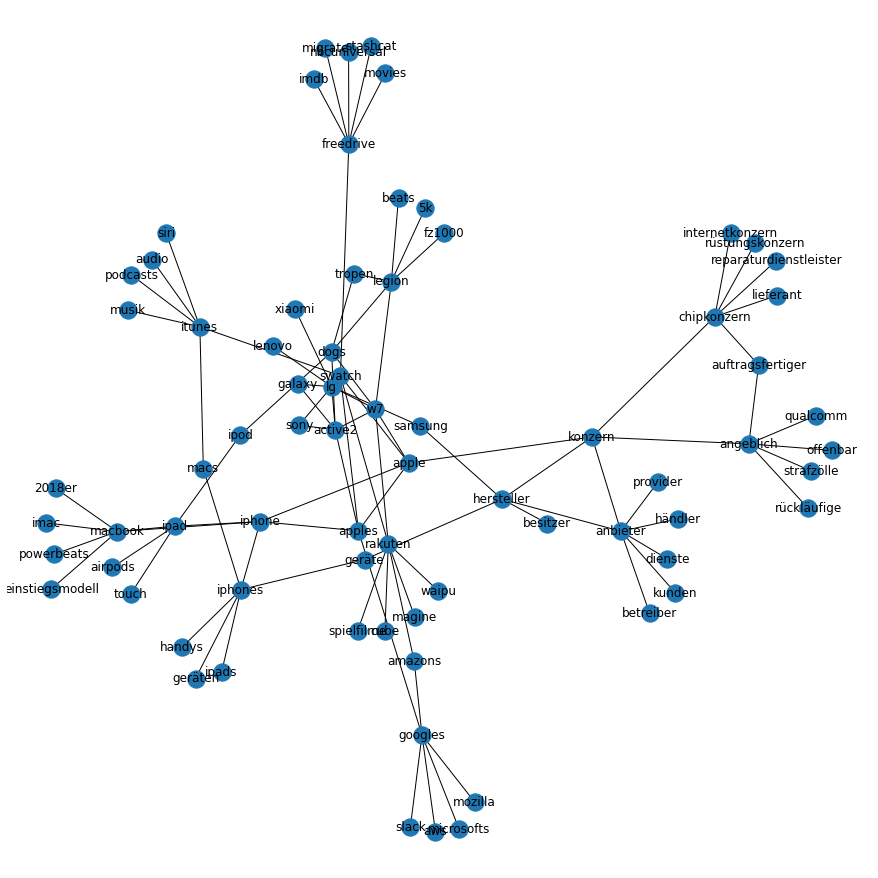

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
nx.draw(G, with_labels=True, pos=nx.spring_layout(G))

In [ ]:
import networkx as nx

G = nx.Graph()
e = model_word.wv
w0 = "apple"
G.add_node(w0)
for (w1, p1) in e.most_similar(w0, topn=10):
    G.add_node(w1)
    G.add_edge(w0, w1, weight=p1 )
    for (w2, p2) in e.most_similar(w1, topn=10):
        G.add_node(w2)
        G.add_edge(w1, w2, weight=p2 )
        for (w3, p3) in e.most_similar(w2, topn=10):
            G.add_node(w3)
            G.add_edge(w2, w3, weight=p3 )

In [ ]:
nx.write_gexf(G, "apple-w2v.gexf")

## Semantische Karte

In [ ]:
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap 


In [ ]:
def plot_2d(vecs, labels, method, filename):
    if method == "tsne":
        tsne = TSNE(n_components=2, random_state=0).fit_transform(vecs)
        df = pd.DataFrame(data = tsne, columns = ["x", "y"])
    elif method == "pca":
        pca = PCA(n_components=2, random_state=0).fit_transform(vecs.toarray())
        df = pd.DataFrame(data = pca, columns = ["x", "y"])
    else:
        um = umap.UMAP(n_components=2, random_state=0).fit_transform(vecs)
        df = pd.DataFrame(data = um, columns = ["x", "y"])
    
    plt.rcParams["figure.figsize"] = (16, 9)
    plt.style.use("seaborn-whitegrid")
    fig, ax = plt.subplots()
    ax.scatter(df.x, df.y, marker="o")

    span = abs(max(df.x) - min(df.x))
    diff = span/150.0
    for i, txt in enumerate(labels):
        fontsize = 10
        ax.annotate(txt, (df.x[i]+diff, df.y[i]), fontsize=fontsize)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.savefig(f'{filename}.png')

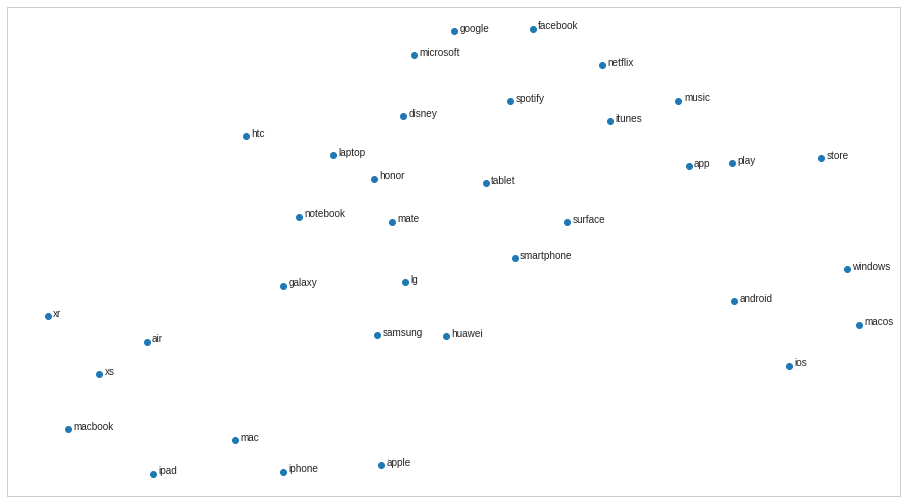

In [ ]:
words = ["apple", "ipad",  "ios", "iphone", "xs", "xr",
         "mac", "macbook", "air", "osx", "macos",
         "android", "google", "samsung", "galaxy", 
         "huawei", "mate", "honor", "htc", "lg", 
         "windows", "microsoft", "surface",
         "laptop", "notebook", "smartphone", "tablet",
         "app", "store", "play", "music", "itunes",
         "netflix", "disney", "spotify", "streaming"
         "amazon", "facebook" ]
vecs = []
labels = []

text = model_word.wv
for w in words:
    if w in text:
        vecs.append(text[w])
        labels.append(w)

plot_2d(vecs, labels, 'umap', "apple")